In [1]:
import os
import abc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
import seaborn as sns

import lightgbm as lgb

from tqdm import tqdm_notebook as tqdm

import warnings
warnings.filterwarnings('ignore')

## Objectives

- EDA


## Note

## Load Data

In [2]:
def read_data():
    files = ['calendar', 'sample_submission', 'sales_train_validation', 'sell_prices']
    
    if os.path.exists('/kaggle/input/m5-forecasting-accuracy'):
        data_dir_path = '/kaggle/input/m5-forecasting-accuracy'
        dst_data = {}
        for file in files:
            print(f'Reading {file} ....')
            dst_data[file] = pd.read_csv(data_dir_path + file + '.csv')
    else:
        data_dir_path = '../data/reduced/'
        dst_data = {}
        for file in files:
            print(f'Reading {file} ....')
            dst_data[file] = pd.read_pickle(data_dir_path + file + '.pkl')
    return dst_data.values()

calendar, submission, sales_train_validation, sell_prices = read_data()

Reading calendar ....
Reading sample_submission ....
Reading sales_train_validation ....
Reading sell_prices ....


In [3]:
print('calendar', calendar.shape)
display(calendar.head())

print('sell_prices', sell_prices.shape)
display(sell_prices.head())

print('sales_train_validation', sales_train_validation.shape)
display(sales_train_validation.head())

print('submission', submission.shape)
display(submission.head())

calendar (1969, 14)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


sell_prices (6841121, 4)


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


sales_train_validation (30490, 1919)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


submission (60980, 29)


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
sales_train_validation['cat_id'].value_counts().sort_index()

FOODS        14370
HOBBIES       5650
HOUSEHOLD    10470
Name: cat_id, dtype: int64

In [5]:
temp = pd.melt(sales_train_validation, 
        id_vars=['id', 'item_id', 'store_id'],
        value_vars=sales_train_validation.columns[sales_train_validation.columns.str.contains('d_\d')],
        var_name='day',
        value_name='sales')

In [6]:
print(temp.shape)
temp.head()

(58327370, 5)


,id,item_id,store_id,day,sales
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,CA_1,d_1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,CA_1,d_1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,CA_1,d_1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,CA_1,d_1,0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,CA_1,d_1,0


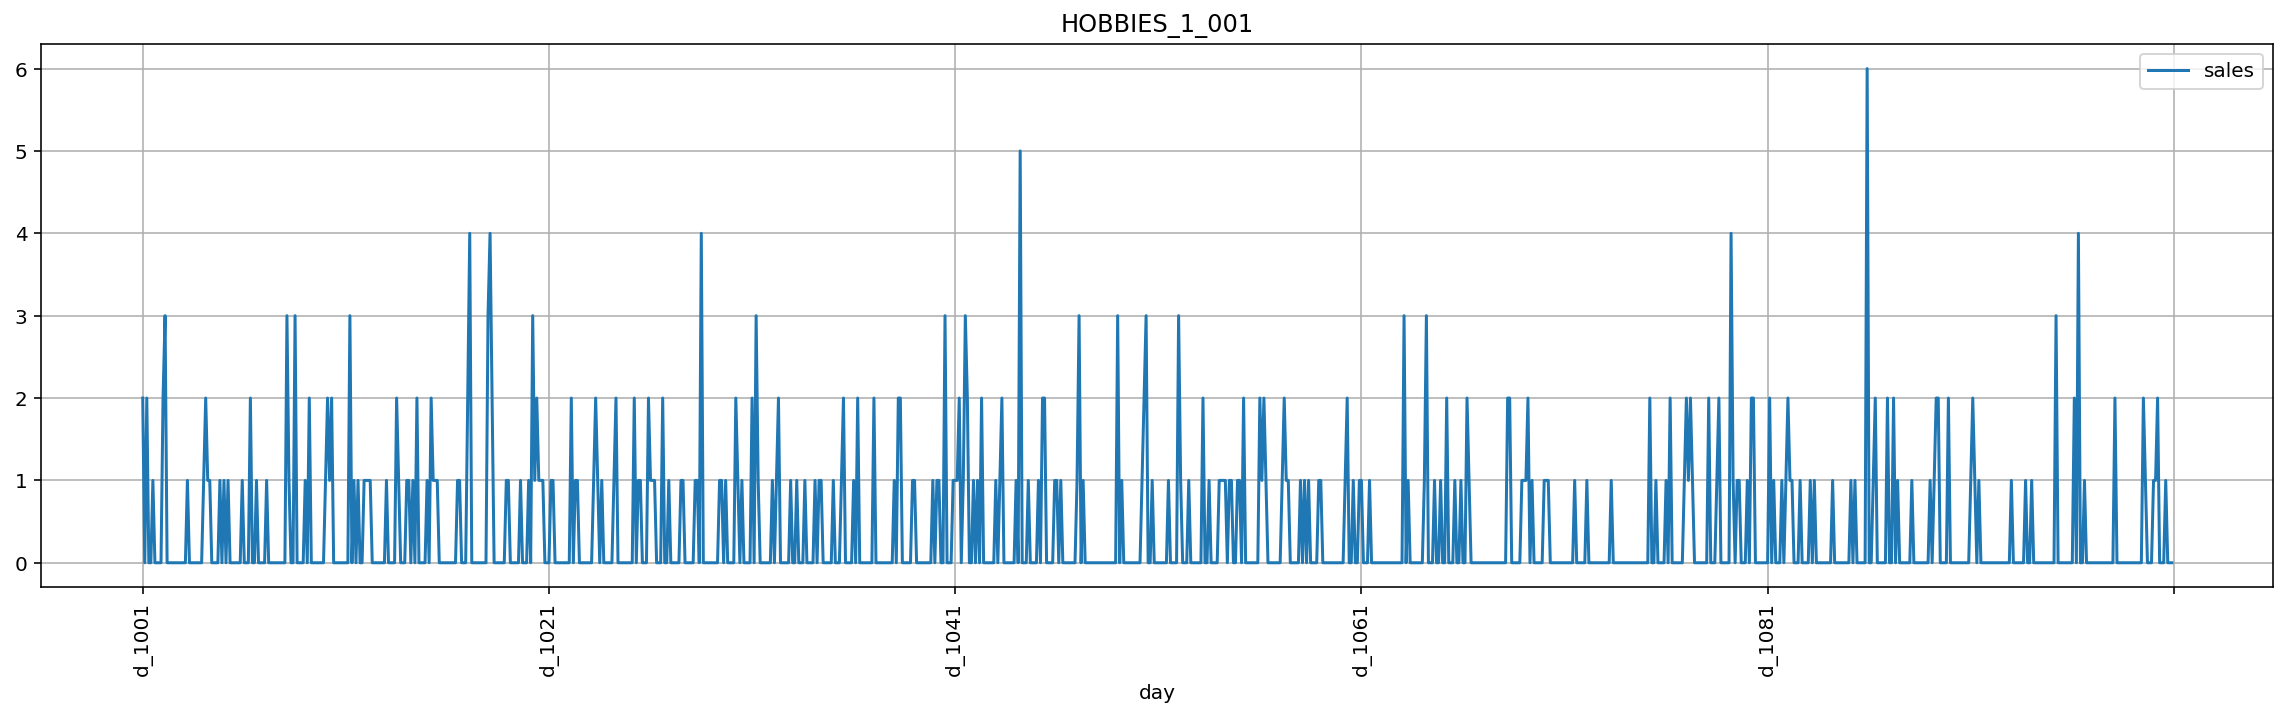

In [16]:
i = 10000
item_id = 'HOBBIES_1_001'
temp.query('item_id==@item_id')[i:i+1000].plot(x='day', y='sales', rot=90, title=item_id, figsize=(20, 5), grid=True)